In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

# Importa i dati

In [2]:
from src.load_data import get_epidemic_data, get_vaccine_data

### Dati relativi all'epidemia

In [3]:
df_epidemic = get_epidemic_data('Israel')
df_epidemic.head()

,Total cases,Active infected,Total deaths,Total recovered,Daily cases (avg 7 days),Daily deaths (avg 7 days)
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0


### Dati relativi alle vaccinazioni

In [4]:
df_vaccine = get_vaccine_data('Israel')
df_vaccine.head()

,% vaccinated with 1 dose,% vaccinated with 2 doses
date,,
2020-12-21,0.37,0.0
2020-12-22,0.89,0.0
2020-12-23,1.61,0.0
2020-12-24,2.46,0.0
2020-12-25,2.90,0.0


### Unione dei due dataframes

In [5]:
df_merged = df_vaccine.join(df_epidemic,on=df_vaccine.index)
df_merged.head()

,% vaccinated with 1 dose,% vaccinated with 2 doses,Total cases,Active infected,Total deaths,Total recovered,Daily cases (avg 7 days),Daily deaths (avg 7 days)
date,,,,,,,,
2020-12-21,0.37,0.0,378259.0,26274.0,3111.0,348874.0,2679.0,15.3
2020-12-22,0.89,0.0,382487.0,28164.0,3136.0,351187.0,3122.4,17.4
2020-12-23,1.61,0.0,385022.0,29996.0,3150.0,351876.0,2854.3,16.6
2020-12-24,2.46,0.0,389678.0,31833.0,3171.0,354674.0,3100.4,17.3
2020-12-25,2.90,0.0,394391.0,33337.0,3186.0,357868.0,3462.7,18.4


# Fit del modello epidemiologico

In [6]:
from src.epi_model import SIR2

In [7]:
ydata_inf = np.array(df_merged['Active infected'])
ydata_rec = np.array(df_merged['Total recovered'])
ydata_inf_tofit = ydata_inf[0:27]

# Il fit originario è stato fatto utilizzando i 27 giorni successivi 
# al 21 Dicembre (giorno di inizio delle vaccinazioni), 
# ossia prima che gli effetti delle vaccinazioni fossero visibili
 
def err_to_minimize(X0):
    '''Questa è la funzione da minimizzare. I parametri liberi sono R0 e tau,
    R0 è legato alla velocità di diffusione del virus, tau è legato alle misure di restrizione'''
    
    r0 = X0[0]
    tau = X0[1] 
 
    abitanti = 8.884*10**6  #abitanti di Israele

    fin_res_SIR=SIR2(abitanti,0.1*r0,0.1,tau,
                     vacc_eff=0,vacc_speed=0,t0=0,  
                     I0=ydata_inf[0],R0=ydata_rec[0],V0=0)
    
    y_pred = fin_res_SIR[2][0:len(ydata_inf_tofit)]
    
    # compute the mean squared error
    mse = np.sqrt(np.mean((y_pred - ydata_inf_tofit)**2))
    
    return mse

In [8]:
from scipy.optimize import minimize
 
minpar = minimize(err_to_minimize,[2,65],options={'return_all':True,'disp':True},method='Nelder-Mead').x 
print('Parametri R0 e tau ottimizzati',minpar)

Optimization terminated successfully.
         Current function value: 1741.815211
         Iterations: 60
         Function evaluations: 116
Parametri R0 e tau ottimizzati [  1.6802753  133.54748916]


### previsioni del modello epidemiologico

In [9]:
# solo lockdown (vacc_speed= 0, tau ricavato dal fit)
pred_lockdown=SIR2(8.884*10**6,0.1*minpar[0],0.1,minpar[1],
                   vacc_eff=0.95,vacc_speed = 0,t0=0,
                   I0=ydata_inf[0],R0=ydata_rec[0],V0=0)

# lockdown più vaccini (vacc_speed = 1.08, tau ricavato dal fit)
# vacc_speed = 1.08 è un parametro di input del modello ed è legato alla velocità con cui vengono somministrate le vaccinazioni
# i vaccinati del modello devono coincidere con i vaccinati reali con doppia dose (vedi grafico in alto a destra nella sezione risultati)
# t0 = 21 indica il giorno di inizio di somministrazione delle 2° dosi
pred_lockdown_vaccine=SIR2(8.884*10**6,0.1*minpar[0],0.1,minpar[1],
                           vacc_eff=0.95,vacc_speed = 1.08,t0=21,
                           I0=ydata_inf[0],R0=ydata_rec[0],V0=0) 

# Risultati

In [10]:
vaccinati_1dose = np.array(df_merged['% vaccinated with 1 dose'])
vaccinati_2dose = np.array(df_merged['% vaccinated with 2 doses'])

incidenza_settimanale = 7/88.84*np.array(df_merged['Daily cases (avg 7 days)'])
decessi_giornalieri = 1/88.84*np.array(df_merged['Daily deaths (avg 7 days)'])

xticks_21 = ['21 Dic','4 Gen','18 Gen','1 Feb','15 Feb','1 Mar','15 Mar','29 Mar','12 Apr','26 Apr']

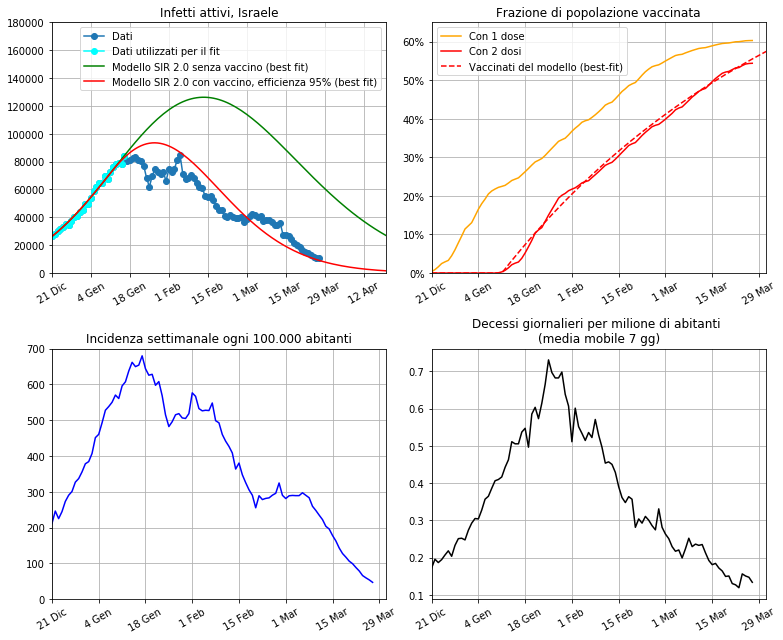

In [11]:
plt.figure(figsize=(11,9))
plt.subplot(2,2,1)
plt.plot(ydata_inf,marker='o',label='Dati')
plt.plot(ydata_inf_tofit,marker='o',label='Dati utilizzati per il fit',color='cyan')
plt.plot(pred_lockdown[2],label='Modello SIR 2.0 senza vaccino (best fit)',color='green')
plt.plot(pred_lockdown_vaccine[2],label='Modello SIR 2.0 con vaccino, efficienza 95% (best fit)',color='red')
plt.title('Infetti attivi, Israele')
plt.xticks(np.arange(0,120,14),xticks_21,rotation=30)
plt.xlim(0,120)
plt.ylim(0,180000)
plt.grid()
plt.legend()
plt.subplot(2,2,2)
plt.title('Frazione di popolazione vaccinata')
plt.plot(vaccinati_1dose,label='Con 1 dose',color='orange')
plt.plot(vaccinati_2dose,label='Con 2 dosi',color='red')
plt.plot(pred_lockdown_vaccine[3]/(8.884*10**6)*100,label='Vaccinati del modello (best-fit)',color='red',linestyle='--')
plt.xticks(np.arange(0,100,14),xticks_21,rotation=30)
plt.yticks(np.arange(0,111,10),['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%','110%'])
plt.ylim(0,65)
plt.xlim(0,len(vaccinati_1dose)+3)
plt.grid()
plt.legend()
plt.subplot(2,2,3)
plt.plot(incidenza_settimanale,color='blue')
plt.title('Incidenza settimanale ogni 100.000 abitanti')
plt.xticks(np.arange(0,100,14),xticks_21,rotation=30)
plt.xlim(0,len(vaccinati_1dose)+3)
plt.ylim(0,700)
plt.grid()
plt.subplot(2,2,4)
plt.plot(decessi_giornalieri,color='black')
plt.title('Decessi giornalieri per milione di abitanti \n(media mobile 7 gg)')
plt.xticks(np.arange(0,100,14),xticks_21,rotation=30)
plt.xlim(0,len(vaccinati_1dose)+3)
plt.grid()
plt.tight_layout()
plt.savefig('results/previsioni-israele.png',dpi=300)
plt.show()